# 5 Min Binary Options Predictions on FX

## Import required libraries to train deep nerual network

In [84]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
#import tensorflow
import time

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn import preprocessing

print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)
#print('Tensorflow-gpu version: ' + tensorflow.__version__)

Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


## Class object to measure time

In [85]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [86]:
Notebook_timer = MeasureTime()

#  

# Part 1. - Import data

# Feature engineering function

    1. Convert OHLC data in to wicks and body sizes of candle stick, also type of candle (Bear or Bull)
    2. Convert datetime in to weekday , hour and minute.
    3. Calculate RSI
    4. Calculate MACD
    5. Calculate Bolinger Bands
    6. Reshape dataframe (Create 10 more columns with last 10 candle data)
    7. Create columns with 11th candle type data (Bear or Bull)
    8. Delete OHLC and datetime data
    9. Convert to numpay array and return

### RSI function - Relative strength index

In [87]:
def relative_strength(prices, n=14):

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi

### MA function - Moving average

In [88]:
def moving_average(x, n, type='simple'):

    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a

### MACD function - Moving average covergance divergance

In [89]:
def moving_average_convergence(x, nslow=26, nfast=12):
    
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow

## Main feature enginering function

In [90]:
def FeatureEnginering(MyRawData):

    #calculate time series
    #MyRawData['WeekDay'] = ((pd.to_datetime(MyRawData['Gmt time'], format='%d.%m.%Y %H:%M:%S.000', utc=True)).dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['Gmt time'] = pd.to_datetime(MyRawData['Gmt time'], format='%d.%m.%Y %H:%M:%S.000', utc=True)
    #MyRawData['Gmt time'] = MyRawData['Gmt time'].dt.datetime
    #MyRawData['Gmt time'] = pd.to_datetime(MyRawData['Gmt time'])
    MyRawData['WeekDay'] = (MyRawData['Gmt time'].dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['Hour'] = (MyRawData['Gmt time'].dt.hour.astype(dtype=np.int64)/23)
    MyRawData['Minute'] = (MyRawData['Gmt time'].dt.minute.astype(dtype=np.int64)/59)
    print('Step 1: Time conversion to Weekday, Hour, Minute')
    
    
   
    
    #calculate candle size parameters in pips
    MyRawData['BodyPips'] = abs((MyRawData['Open']-MyRawData['Close']) * 10000)
    MyRawData['WickUpPips'] = (abs(MyRawData['Open']-MyRawData['High']) * 10000)
    MyRawData['WickDownPips'] = (abs(MyRawData['Close']-MyRawData['Low']) * 10000)
    #calculate candle type
    MyRawData['type'] = 0
    MyRawData.loc[MyRawData['Close'] > MyRawData['Open'] , 'type'] = 1
    print('Step 2: Calculation Body,Wicks sizes and type of candle')
    
    MyRawData['EmaSlow'], MyRawData['EmaFast'], MyRawData['MACD'] = moving_average_convergence(MyRawData['Close'].values, nslow=26, nfast=12)                   
    print('Step 3: Calculate MACD')
    MyRawData['Ema9'] = moving_average(MyRawData['MACD'].values, 9, type='exponential')
    print('Step 4: Calculate EMA 9')
    MyRawData['RSI'] = relative_strength(MyRawData['Close'].values) 
    print('Step 5: Calculate RSI')

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    MyRawData=MyRawData[::-1]
    MyRawData['Rolling Mean'] = MyRawData['Close'].rolling(window=21).mean()
    MyRawData['Bollinger High'] = MyRawData['Close'].rolling(window=21).mean() + (MyRawData['Close'].rolling(window=21).std() * 2)
    MyRawData['Bollinger Low'] = MyRawData['Close'].rolling(window=21).mean() - (MyRawData['Close'].rolling(window=21).std() * 2)
    MyRawData=MyRawData[::-1]
    print('Step 6: Calculate Bolinger Bands')
    
    #add 10 more history candle sticks
    for CandleCount in range(10):
        ActualCandleCount = CandleCount + 1
        MyRawData['BodyPips' + '_' + str(ActualCandleCount)] = MyRawData['BodyPips'].shift(-ActualCandleCount)
        MyRawData['WickUpPips' + '_' + str(ActualCandleCount)] = MyRawData['WickUpPips'].shift(-ActualCandleCount)
        MyRawData['WickDownPips' + '_' + str(ActualCandleCount)] = MyRawData['WickDownPips'].shift(-ActualCandleCount)
        MyRawData['WeekDay' + '_' + str(ActualCandleCount)] = MyRawData['WeekDay'].shift(-ActualCandleCount)
        MyRawData['Hour' + '_' + str(ActualCandleCount)] = MyRawData['Hour'].shift(-ActualCandleCount)
        MyRawData['Minute' + '_' + str(ActualCandleCount)] = MyRawData['Minute'].shift(-ActualCandleCount)
        MyRawData['type' + '_' + str(ActualCandleCount)] = MyRawData['type'].shift(-ActualCandleCount)
        MyRawData['EmaSlow' + '_' + str(ActualCandleCount)] = MyRawData['EmaSlow'].shift(-ActualCandleCount)
        MyRawData['EmaFast' + '_' + str(ActualCandleCount)] = MyRawData['EmaFast'].shift(-ActualCandleCount)
        MyRawData['MACD' + '_' + str(ActualCandleCount)] = MyRawData['MACD'].shift(-ActualCandleCount)
        MyRawData['Ema9' + '_' + str(ActualCandleCount)] = MyRawData['Ema9'].shift(-ActualCandleCount)
        MyRawData['RSI' + '_' + str(ActualCandleCount)] = MyRawData['RSI'].shift(-ActualCandleCount)
        MyRawData['Rolling Mean' + '_' + str(ActualCandleCount)] = MyRawData['Rolling Mean'].shift(-ActualCandleCount)
        MyRawData['Bollinger High' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger High'].shift(-ActualCandleCount)
        MyRawData['Bollinger Low' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger Low'].shift(-ActualCandleCount)
        print('Step 7: Generating candle backwards [Candle: ' + str(ActualCandleCount) +']')

    #populate las column with the output
    MyRawData['output'] = 0
    MyRawData.loc[MyRawData['Close'] < MyRawData['Close'].shift(5), 'output'] = 1
    print('Step 8: Generating prediction column')
    

    #del MyRawData['Gmt time']
    del MyRawData['Open']
    del MyRawData['High']
    del MyRawData['Low']
    del MyRawData['Close']
    del MyRawData['Volume']
    print('Step 9: Deleting waste columns')

    return MyRawData[50:-50]



#  

# Import data from CSV to Pandas

In [91]:
ddf_pd = pd.read_csv('EURUSD_2018.csv')
#ddf_pd = pd.read_csv('EURUSD_2018.csv')
ddf_pd = ddf_pd[::-1]
ddf_pd = ddf_pd.head(400000)

## Raw data

## Feature engineer

In [92]:
ddf_pd=FeatureEnginering(ddf_pd)

Step 1: Time conversion to Weekday, Hour, Minute
Step 2: Calculation Body,Wicks sizes and type of candle
Step 3: Calculate MACD
Step 4: Calculate EMA 9
Step 5: Calculate RSI


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Step 6: Calculate Bolinger Bands
Step 7: Generating candle backwards [Candle: 1]
Step 7: Generating candle backwards [Candle: 2]
Step 7: Generating candle backwards [Candle: 3]
Step 7: Generating candle backwards [Candle: 4]
Step 7: Generating candle backwards [Candle: 5]
Step 7: Generating candle backwards [Candle: 6]
Step 7: Generating candle backwards [Candle: 7]
Step 7: Generating candle backwards [Candle: 8]
Step 7: Generating candle backwards [Candle: 9]
Step 7: Generating candle backwards [Candle: 10]
Step 8: Generating prediction column
Step 9: Deleting waste columns


In [93]:
ddf_pd.head(10)

,Gmt time,WeekDay,Hour,Minute,BodyPips,WickUpPips,WickDownPips,type,EmaSlow,EmaFast,...,type_10,EmaSlow_10,EmaFast_10,MACD_10,Ema9_10,RSI_10,Rolling Mean_10,Bollinger High_10,Bollinger Low_10,output
394966,2018-12-31 21:10:00+00:00,0.0,0.913043,0.169492,0.3,0.6,0.3,1,1.146125,1.145878,...,1.0,1.145856,1.145740,-0.000116,-0.000150,26.551548,1.145901,1.146140,1.145662,1
394965,2018-12-31 21:09:00+00:00,0.0,0.913043,0.152542,0.0,0.2,0.0,0,1.146090,1.145853,...,0.0,1.145842,1.145724,-0.000118,-0.000135,26.551548,1.145913,1.146113,1.145713,1
394964,2018-12-31 21:08:00+00:00,0.0,0.913043,0.135593,0.3,0.4,0.4,1,1.146056,1.145838,...,0.0,1.145830,1.145710,-0.000120,-0.000124,39.843468,1.145926,1.146071,1.145780,1
394963,2018-12-31 21:07:00+00:00,0.0,0.913043,0.118644,0.1,0.2,0.0,0,1.146022,1.145837,...,0.0,1.145820,1.145711,-0.000109,-0.000117,53.451291,1.145934,1.146043,1.145824,1
394962,2018-12-31 21:06:00+00:00,0.0,0.913043,0.101695,0.0,0.1,0.1,0,1.145991,1.145835,...,0.0,1.145810,1.145713,-0.000097,-0.000114,53.451291,1.145935,1.146041,1.145829,1
394961,2018-12-31 21:05:00+00:00,0.0,0.913043,0.084746,0.2,0.4,0.3,1,1.145949,1.145821,...,0.0,1.145799,1.145722,-0.000077,-0.000111,56.494869,1.145938,1.146039,1.145836,1
394960,2018-12-31 21:04:00+00:00,0.0,0.913043,0.067797,0.0,0.3,0.1,0,1.145918,1.145801,...,0.0,1.145795,1.145733,-0.000062,-0.000107,61.267668,1.145938,1.146039,1.145836,1
394959,2018-12-31 21:03:00+00:00,0.0,0.913043,0.050847,0.1,0.2,0.1,1,1.145894,1.145783,...,0.0,1.145800,1.145746,-0.000054,-0.000103,64.281906,1.145932,1.146038,1.145827,1
394958,2018-12-31 21:02:00+00:00,0.0,0.913043,0.033898,0.5,0.5,0.6,1,1.145883,1.145771,...,1.0,1.145804,1.145766,-0.000038,-0.000096,65.992004,1.145926,1.146025,1.145827,1
394957,2018-12-31 21:01:00+00:00,0.0,0.913043,0.016949,0.4,0.9,0.5,1,1.145871,1.145755,...,0.0,1.145802,1.145783,-0.000018,-0.000088,57.151690,1.145919,1.146001,1.145837,1


## Data with features applied

# Split data by Input, Output & Traning, Validation, Testing data and decoded list of datetimes

In [ ]:
D = ddf_pd.values[:, :2]

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X = ddf_pd.values[:, 1:166]
X = min_max_scaler.fit_transform(X)

In [ ]:
Y = ddf_pd.values[:, 166:]
del ddf_pd

# Split data by training, validation and test

In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X,Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
del X
del Y

In [ ]:
D_train, D_val_and_test = train_test_split(D, test_size=0.5)
D_val, D_test = train_test_split(D_val_and_test, test_size=0.5)
del D

## Final dataset :

In [ ]:
print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))

#   

# Part 2. -  Train Deep Learning model

# Create the deep learning model

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=165, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train the model

In [ ]:
hist = model.fit(X_train, Y_train,batch_size=500, epochs=15,validation_data=(X_val, Y_val))

# Evaluate trained model on new data

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)
predictions = model.predict(X_test)

# Part 3. -  Get data insights

## Function to calculate won and lost trades on data sample:

In [ ]:
def calculate_win_loss(confidence,predictions,target):
    WON = 0
    LOST = 0
    counter = 0
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) == target[counter]:
                WON = WON + 1
            else:
                LOST = LOST + 1
        counter = counter + 1
    return WON,LOST

In [21]:
won_trades,lost_trades = calculate_win_loss(0.98,predictions,Y_test)
print('Trades won: ' + str(won_trades) + ', Trades lost: ' + str(lost_trades))
print('Profitability: ' + str(round((won_trades*100)/(won_trades+lost_trades),2)) + '%')


Trades won: 60, Trades lost: 2773
Profitability: 2.12%


## Function to calculate consequitive trades:

In [22]:
def calculate_consequitive_trades(confidence,predictions,target):
    counter = 0
    ConsequtiveStats = []
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) == target[counter]:
                ConsequtiveStats.append(1)
            else:
                ConsequtiveStats.append(0)
        counter = counter + 1
    z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    
    MaxLost = 0
    MaxWon = 0
    for a in z:
        if a[0]==0:
            if a[1] > MaxLost: MaxLost = a[1]
        else:
            if a[1] > MaxWon: MaxWon = a[1]     
    return MaxWon,MaxLost

In [23]:
max_won,max_lost = calculate_consequitive_trades(0.98,predictions,Y_test)
print('Max consequitive wins: ' + str(max_won) + ', Max consequitive looses: ' + str(max_lost))

Max consequitive wins: 2, Max consequitive looses: 246


## Function to calculate trades per weekday

In [24]:
def calculate_week_trades(confidence,predictions,target,decoded_weekdays):
    counter = 0
    WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) == target[counter]:
                trade_status = 0
            else:
                trade_status = 1
            if decoded_weekdays[counter][1] == 0: WeekDayStats['Monday'][trade_status] = WeekDayStats['Monday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.25: WeekDayStats['Tuesday'][trade_status] = WeekDayStats['Tuesday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.5: WeekDayStats['Wendsday'][trade_status] = WeekDayStats['Wendsday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.75: WeekDayStats['Thursday'][trade_status] = WeekDayStats['Thursday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 1: WeekDayStats['Friday'][trade_status] = WeekDayStats['Friday'][trade_status] + 1
        counter = counter + 1
        
    Weekdays = round(len(predictions)/7200,0)    
    for key, value in WeekDayStats.items():
        value[0] = round(value[0]/Weekdays,0)
        value[1] = round(value[1]/Weekdays,0)
    
    return WeekDayStats,Weekdays

In [25]:
week_day_trades,traded_weeks = calculate_week_trades(0.98,predictions,Y_test,D_test)
print('Data gathered from ' + str(traded_weeks) + ' weeks')
print('Average trades on Monday =  Won: ' + str(week_day_trades['Monday'][0]) + ', Lost: ' + str(week_day_trades['Monday'][1]))
print('Average trades on Tuesday =  Won: ' + str(week_day_trades['Tuesday'][0]) + ', Lost: ' + str(week_day_trades['Tuesday'][1]))
print('Average trades on Wendsday =  Won: ' + str(week_day_trades['Wendsday'][0]) + ', Lost: ' + str(week_day_trades['Wendsday'][1]))
print('Average trades on Thursday =  Won: ' + str(week_day_trades['Thursday'][0]) + ', Lost: ' + str(week_day_trades['Thursday'][1]))
print('Average trades on Friday =  Won: ' + str(week_day_trades['Friday'][0]) + ', Lost: ' + str(week_day_trades['Friday'][1]))

Data gathered from 14.0 weeks
Average trades on Monday =  Won: 1.0, Lost: 40.0
Average trades on Tuesday =  Won: 1.0, Lost: 40.0
Average trades on Wendsday =  Won: 1.0, Lost: 37.0
Average trades on Thursday =  Won: 1.0, Lost: 41.0
Average trades on Friday =  Won: 1.0, Lost: 36.0


## Function to calculate P&L

In [26]:
def calculate_p_and_l(confidence,predictions,target,trade_return,starting_balance,trade_percent,withdraw_percent):
    counter = 0
    withdraws = []
    balance = []
    balance.append(starting_balance)
    
    for prediction_check in predictions:
        if counter % 7200 == 0: 
            if balance[len(balance)-1] > 10*starting_balance:
                withdraws.append(balance[len(balance)-1] *withdraw_percent)
                balance[len(balance)-1] = balance[len(balance)-1] * (1-withdraw_percent)
            else:
                withdraws.append(0)
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            
            next_balance = balance[len(balance)-1]
            trade_size = next_balance*trade_percent
            next_balance = next_balance - trade_size
            
            if np.argmax(predictions[counter]) == target[counter]:
                next_balance = next_balance + (trade_size*trade_return)
            balance.append(round(next_balance,2))
            
        counter = counter + 1
    return balance,withdraws

In [27]:
profit_loss,weekly_withdraws = calculate_p_and_l(0.98,predictions,Y_test,1.8,50,0.05,0.7)

#   

# Part 4. -  Plot the charts

## EURUSD - validation data

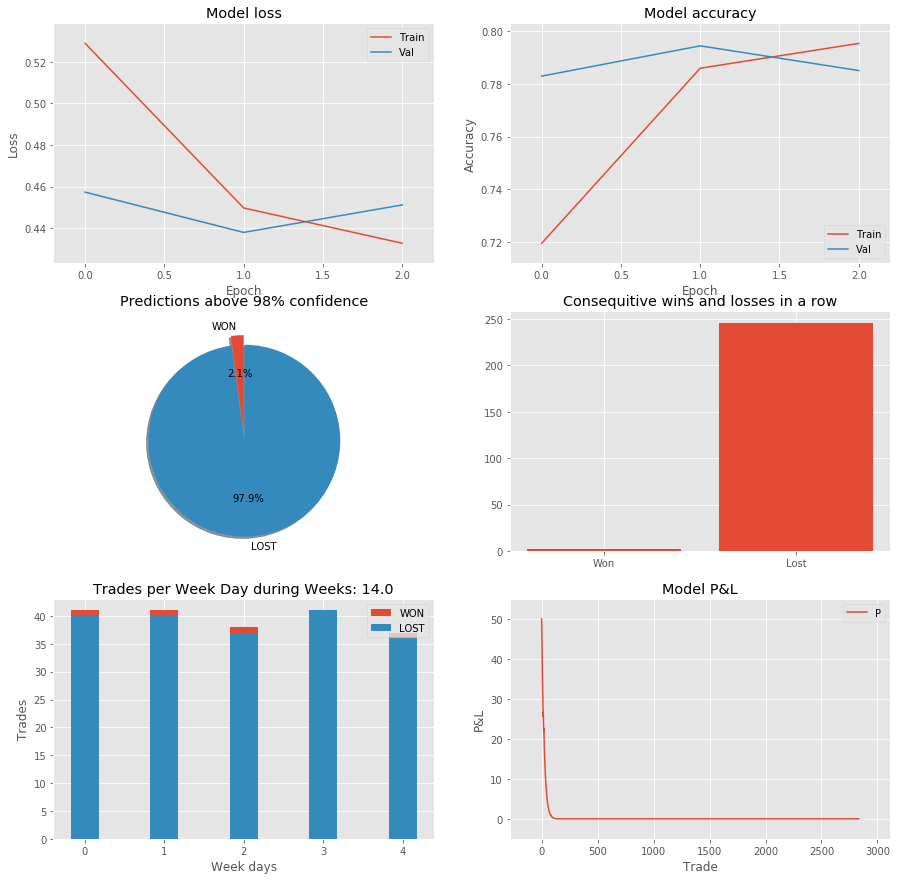

In [28]:
plt.style.use('ggplot')
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(321)
ax.margins(0.1) 
ax.plot(hist.history['loss'])
ax.plot(hist.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'], loc='upper right')

ax2 = f.add_subplot(322)
ax2.margins(0.1) 
ax2.plot(hist.history['acc'])
ax2.plot(hist.history['val_acc'])
ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'], loc='lower right')

ax3 = f.add_subplot(323)
labels = 'WON', 'LOST'
sizes = [won_trades, lost_trades]
explode = (0, 0.1)  
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.set_title('Predictions above 98% confidence')

ax4 = f.add_subplot(324)
ax4.set_title('Consequitive wins and losses in a row')
x = ['Won','Lost']
ax4.bar(x, [max_won,max_lost])
ax4.set_xticks(x, ('Won','Lost'))

ax5 = f.add_subplot(325)
TradesWonWeekDay = (sum(week_day_trades['Monday']), sum(week_day_trades['Tuesday']),sum(week_day_trades['Wendsday']), sum(week_day_trades['Monday']), sum(week_day_trades['Friday']))
TradesLostWeekDay = (week_day_trades['Monday'][1], week_day_trades['Tuesday'][1], week_day_trades['Wendsday'][1], week_day_trades['Thursday'][1], week_day_trades['Friday'][1])
p1 = plt.bar(np.arange(5) , TradesWonWeekDay, 0.35 )
p2 = plt.bar(np.arange(5), TradesLostWeekDay, 0.35 )
ax5.set_ylabel('Trades')
ax5.set_title('Trades per Week Day during Weeks: ' + str(traded_weeks))
ax5.set_xticks(np.arange(5), ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
ax5.set_xlabel('Week days')
ax5.legend((p1[0], p2[0]), ('WON', 'LOST'))

ax6 = f.add_subplot(326)
ax6.margins(0.1) 
ax6.plot(profit_loss)
ax6.set_title('Model P&L')
ax6.set_ylabel('P&L')
ax6.set_xlabel('Trade')
ax6.legend('Profit', loc='upper right')

plt.show()



# Part 5. -  Save and load model

## save model

In [29]:
model.save("model3.h5")
print("Saved model to disk")

Saved model to disk


## load model

In [30]:
from keras.models import load_model

# load model
model = load_model('model3.h5')
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               21248     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
_________________________________________________________________


# Part 6. -  Evaluate model on other asset

### Load GBP/USD  1 minute candle data from csv.

In [31]:

ddf_pd2 = pd.read_csv('GBPUSD_2018.csv')
ddf_pd2=ddf_pd2[::-1]
ddf_pd2=ddf_pd2.head(400000)

### Create features for loaded dataset

In [32]:

ddf_pd2=FeatureEnginering(ddf_pd2)

Step 1: Time conversion to Weekday, Hour, Minute
Step 2: Calculation Body,Wicks sizes and type of candle
Step 3: Calculate MACD
Step 4: Calculate EMA 9
Step 5: Calculate RSI


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Step 6: Calculate Bolinger Bands
Step 7: Generating candle backwards [Candle: 1]
Step 7: Generating candle backwards [Candle: 2]
Step 7: Generating candle backwards [Candle: 3]
Step 7: Generating candle backwards [Candle: 4]
Step 7: Generating candle backwards [Candle: 5]
Step 7: Generating candle backwards [Candle: 6]
Step 7: Generating candle backwards [Candle: 7]
Step 7: Generating candle backwards [Candle: 8]
Step 7: Generating candle backwards [Candle: 9]
Step 7: Generating candle backwards [Candle: 10]
Step 8: Generating prediction column
Step 9: Deleting waste columns


### Slice the dataset to get list of date times

In [33]:

D = ddf_pd2.values[:, :2]

### Slice and normalize the dataset to get the input format

In [34]:

min_max_scaler = preprocessing.MinMaxScaler()
X = ddf_pd2.values[:, 1:166]
X = min_max_scaler.fit_transform(X)

### Slice the dataset to get the output format

In [35]:

Y = ddf_pd2.values[:, 166:]
del ddf_pd2

### Make model predictions on GBP/USD dataset.

In [36]:

test_loss, test_acc = model.evaluate(X, Y)
print('Test accuracy:', test_acc)
predictions = model.predict(X)

399900/399900 [==============================] - 33s 83us/step
Test accuracy: 0.5308402100516189


### Calculate the win/loss ratio

In [37]:
won_trades,lost_trades = calculate_win_loss(0.99,predictions,Y)
print('Trades won: ' + str(won_trades) + ', Trades lost: ' + str(lost_trades))
print('Profitability: ' + str(round((won_trades*100)/(won_trades+lost_trades),2)) + '%')

Trades won: 1523, Trades lost: 29096
Profitability: 4.97%


### Calculate the max losses and wins in a row

In [38]:
max_won,max_lost = calculate_consequitive_trades(0.99,predictions,Y)
print('Max consequitive wins: ' + str(max_won) + ', Max consequitive looses: ' + str(max_lost))

Max consequitive wins: 11, Max consequitive looses: 356


### Calculate the average trades per week

In [39]:
week_day_trades,traded_weeks = calculate_week_trades(0.99,predictions,Y,D)
print('Data gathered from ' + str(traded_weeks) + ' weeks')
print('Average trades on Monday =  Won: ' + str(week_day_trades['Monday'][0]) + ', Lost: ' + str(week_day_trades['Monday'][1]))
print('Average trades on Tuesday =  Won: ' + str(week_day_trades['Tuesday'][0]) + ', Lost: ' + str(week_day_trades['Tuesday'][1]))
print('Average trades on Wendsday =  Won: ' + str(week_day_trades['Wendsday'][0]) + ', Lost: ' + str(week_day_trades['Wendsday'][1]))
print('Average trades on Thursday =  Won: ' + str(week_day_trades['Thursday'][0]) + ', Lost: ' + str(week_day_trades['Thursday'][1]))
print('Average trades on Friday =  Won: ' + str(week_day_trades['Friday'][0]) + ', Lost: ' + str(week_day_trades['Friday'][1]))

Data gathered from 56.0 weeks
Average trades on Monday =  Won: 3.0, Lost: 65.0
Average trades on Tuesday =  Won: 3.0, Lost: 87.0
Average trades on Wendsday =  Won: 5.0, Lost: 102.0
Average trades on Thursday =  Won: 6.0, Lost: 121.0
Average trades on Friday =  Won: 5.0, Lost: 111.0


### Calculate the profit and loss ratios togather with weekly withdraws

In [40]:
profit_loss,weekly_withdraws = calculate_p_and_l(0.99,predictions,Y,1.8,50,0.05,0.5)

### Plot the charts for GBP/USD simulation

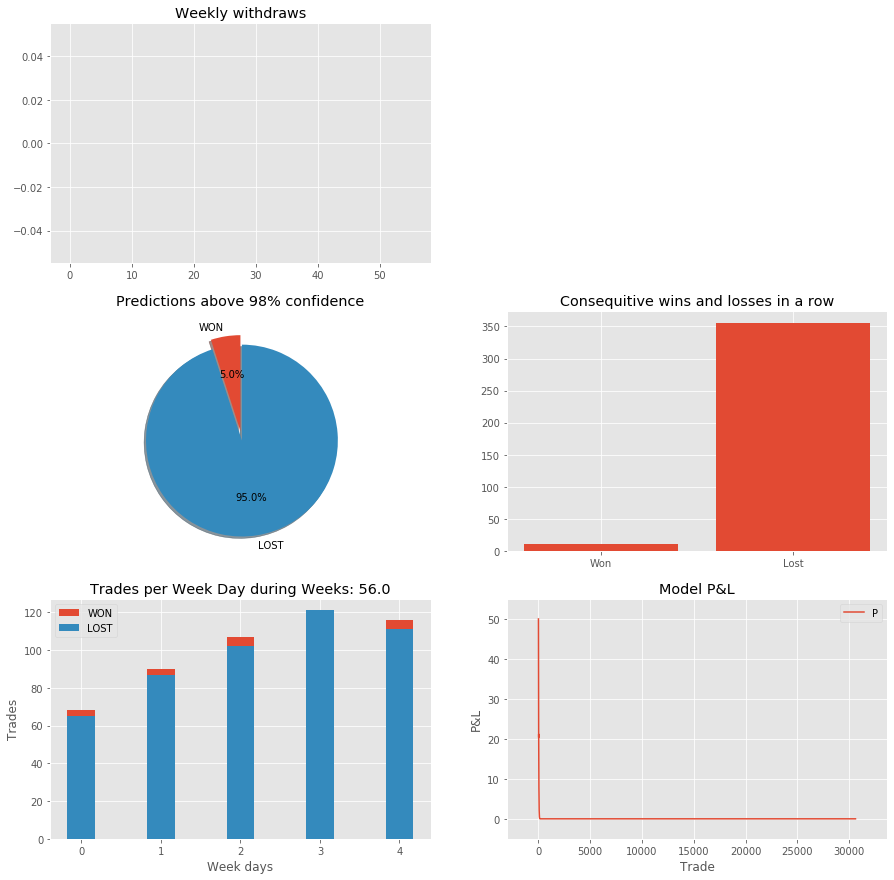

In [41]:
plt.style.use('ggplot')
f = plt.figure(figsize=(15,15))


ax1 = f.add_subplot(321)
ax1.set_title('Weekly withdraws')
ax1.bar(np.arange(len(weekly_withdraws)),weekly_withdraws)


ax3 = f.add_subplot(323)
labels = 'WON', 'LOST'
sizes = [won_trades, lost_trades]
explode = (0, 0.1)  
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.set_title('Predictions above 98% confidence')

ax4 = f.add_subplot(324)
ax4.set_title('Consequitive wins and losses in a row')
x = ['Won','Lost']
ax4.bar(x, [max_won,max_lost])
ax4.set_xticks(x, ('Won','Lost'))

ax5 = f.add_subplot(325)
TradesWonWeekDay = (sum(week_day_trades['Monday']), sum(week_day_trades['Tuesday']),sum(week_day_trades['Wendsday']), sum(week_day_trades['Monday']), sum(week_day_trades['Friday']))
TradesLostWeekDay = (week_day_trades['Monday'][1], week_day_trades['Tuesday'][1], week_day_trades['Wendsday'][1], week_day_trades['Thursday'][1], week_day_trades['Friday'][1])
p1 = plt.bar(np.arange(5) , TradesWonWeekDay, 0.35 )
p2 = plt.bar(np.arange(5), TradesLostWeekDay, 0.35 )
ax5.set_ylabel('Trades')
ax5.set_title('Trades per Week Day during Weeks: ' + str(traded_weeks))
ax5.set_xticks(np.arange(5), ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
ax5.set_xlabel('Week days')
ax5.legend((p1[0], p2[0]), ('WON', 'LOST'))

ax6 = f.add_subplot(326)
ax6.margins(0.1) 
ax6.plot(profit_loss)
ax6.set_title('Model P&L')
ax6.set_ylabel('P&L')
ax6.set_xlabel('Trade')
ax6.legend('Profit', loc='upper right')

plt.show()



# Conclusion

Looks like we manage to get ultra bad performanace... In fact our model had Profitability: 2.39% rate which is so bad, but wait... We know that Binary Options is a binary game (0,1). So if our model has 2.39% succes rate on predicting the direction, we can reverse it by multpiplication all our predictions by -1 ! Yes, in theory if our model will make a prediction for CALL option signal, we will just reverse it to PUT option and so on... Now, let's play with the numbers, our model has 2.39% so if we can reverse the signals we will get 100%-2.39%=97.61%! OK... it all looks fine in theory, let's make it a try and code it.

### Step 1. - Reverse all the analytics functions

#    

#### Calculation

#### Reverse function to calculate won and lost trades on data sample:

In [60]:
def reversed_calculate_win_loss(confidence,predictions,target):
    WON = 0
    LOST = 0
    counter = 0
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) != target[counter]:
                WON = WON + 1
            else:
                LOST = LOST + 1
        counter = counter + 1
    return WON,LOST

##### Reversed function to calculate consequitive trades:

In [43]:
def reversed_calculate_consequitive_trades(confidence,predictions,target):
    counter = 0
    ConsequtiveStats = []
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) != target[counter]:
                ConsequtiveStats.append(1)
            else:
                ConsequtiveStats.append(0)
        counter = counter + 1
    z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    
    MaxLost = 0
    MaxWon = 0
    for a in z:
        if a[0]==0:
            if a[1] > MaxLost: MaxLost = a[1]
        else:
            if a[1] > MaxWon: MaxWon = a[1]     
    return MaxWon,MaxLost

##### Reversed function to calculate trades per weekday

In [44]:
def reversed_recalculate_week_trades(confidence,predictions,target,decoded_weekdays):
    counter = 0
    WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) != target[counter]:
                trade_status = 0
            else:
                trade_status = 1
            if decoded_weekdays[counter][1] == 0: WeekDayStats['Monday'][trade_status] = WeekDayStats['Monday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.25: WeekDayStats['Tuesday'][trade_status] = WeekDayStats['Tuesday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.5: WeekDayStats['Wendsday'][trade_status] = WeekDayStats['Wendsday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.75: WeekDayStats['Thursday'][trade_status] = WeekDayStats['Thursday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 1: WeekDayStats['Friday'][trade_status] = WeekDayStats['Friday'][trade_status] + 1
        counter = counter + 1
        
    Weekdays = round(len(predictions)/7200,0)    
    for key, value in WeekDayStats.items():
        value[0] = round(value[0]/Weekdays,0)
        value[1] = round(value[1]/Weekdays,0)
    
    return WeekDayStats,Weekdays

##### Reversed function to calculate P&L

In [45]:
def reversed_calculate_p_and_l(confidence,predictions,target,trade_return,starting_balance,trade_percent,withdraw_percent):
    counter = 0
    withdraws = []
    balance = []
    balance.append(starting_balance)
    
    for prediction_check in predictions:
        if counter % 7200 == 0: 
            if balance[len(balance)-1] > 10*starting_balance:
                withdraws.append(balance[len(balance)-1] *withdraw_percent)
                balance[len(balance)-1] = balance[len(balance)-1] * (1-withdraw_percent)
            else:
                withdraws.append(0)
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            
            next_balance = balance[len(balance)-1]
            trade_size = next_balance*trade_percent
            next_balance = next_balance - trade_size
            
            if np.argmax(predictions[counter]) != target[counter]:
                next_balance = next_balance + (trade_size*trade_return)
            balance.append(round(next_balance,2))
            
        counter = counter + 1
    return balance,withdraws

##### Reversed function to calculate won and lost trades on data sample:

In [46]:
def reversed_calculate_win_loss(confidence,predictions,target):
    WON = 0
    LOST = 0
    counter = 0
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) != target[counter]:
                WON = WON + 1
            else:
                LOST = LOST + 1
        counter = counter + 1
    return WON,LOST

##### Reversed function to calculate consequitive trades:

In [64]:
def reversed_calculate_consequitive_trades(confidence,predictions,target):
    counter = 0
    ConsequtiveStats = []
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) != target[counter]:
                ConsequtiveStats.append(1)
            else:
                ConsequtiveStats.append(0)
        counter = counter + 1
    z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    
    MaxLost = 0
    MaxWon = 0
    for a in z:
        if a[0]==0:
            if a[1] > MaxLost: MaxLost = a[1]
        else:
            if a[1] > MaxWon: MaxWon = a[1]     
    return MaxWon,MaxLost

#### Reversed function to calculate trades per weekday

In [48]:
def reversed_calculate_week_trades(confidence,predictions,target,decoded_weekdays):
    counter = 0
    WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
    for prediction_check in predictions:
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) != target[counter]:
                trade_status = 0
            else:
                trade_status = 1
            if decoded_weekdays[counter][1] == 0: WeekDayStats['Monday'][trade_status] = WeekDayStats['Monday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.25: WeekDayStats['Tuesday'][trade_status] = WeekDayStats['Tuesday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.5: WeekDayStats['Wendsday'][trade_status] = WeekDayStats['Wendsday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.75: WeekDayStats['Thursday'][trade_status] = WeekDayStats['Thursday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 1: WeekDayStats['Friday'][trade_status] = WeekDayStats['Friday'][trade_status] + 1
        counter = counter + 1
        
    Weekdays = round(len(predictions)/7200,0)    
    for key, value in WeekDayStats.items():
        value[0] = round(value[0]/Weekdays,0)
        value[1] = round(value[1]/Weekdays,0)
    
    return WeekDayStats,Weekdays

##### Reversed function to calculate P&L

In [74]:
def reversed_calculate_p_and_l(confidence,predictions,target,trade_return,starting_balance,trade_percent,withdraw_percent):
    counter = 0
    withdraws = []
    balance = []
    balance.append(starting_balance)
    
    for prediction_check in predictions:
        if counter % 7200 == 0: 
            if balance[len(balance)-1] > 10*starting_balance:
                withdraws.append(balance[len(balance)-1] *withdraw_percent)
                balance[len(balance)-1] = balance[len(balance)-1] * (1-withdraw_percent)
            else:
                withdraws.append(0)
        if prediction_check > confidence: # or prediction_check < 1-confidence:
            
            next_balance = balance[len(balance)-1]
            trade_size = next_balance*trade_percent
            next_balance = next_balance - trade_size
            
            if np.argmax(predictions[counter]) != target[counter]:
                next_balance = next_balance + (trade_size*trade_return)
            balance.append(round(next_balance,2))
            
        counter = counter + 1
    return balance,withdraws

### Step 2: Load the test dataset

## load model

In [50]:
from keras.models import load_model

# load model
model = load_model('model3.h5')
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               21248     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
_________________________________________________________________


# Part 6. -  Evaluate model on other asset

### Load GBP/USD  1 minute candle data from csv.

In [51]:

ddf_pd2 = pd.read_csv('GBPUSD_2018.csv')
ddf_pd2=ddf_pd2[::-1]
ddf_pd2=ddf_pd2.head(400000)

### Create features for loaded dataset

In [52]:

ddf_pd2=FeatureEnginering(ddf_pd2)

Step 1: Time conversion to Weekday, Hour, Minute
Step 2: Calculation Body,Wicks sizes and type of candle
Step 3: Calculate MACD
Step 4: Calculate EMA 9
Step 5: Calculate RSI


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Step 6: Calculate Bolinger Bands
Step 7: Generating candle backwards [Candle: 1]
Step 7: Generating candle backwards [Candle: 2]
Step 7: Generating candle backwards [Candle: 3]
Step 7: Generating candle backwards [Candle: 4]
Step 7: Generating candle backwards [Candle: 5]
Step 7: Generating candle backwards [Candle: 6]
Step 7: Generating candle backwards [Candle: 7]
Step 7: Generating candle backwards [Candle: 8]
Step 7: Generating candle backwards [Candle: 9]
Step 7: Generating candle backwards [Candle: 10]
Step 8: Generating prediction column
Step 9: Deleting waste columns


### Slice the dataset to get list of date times

In [53]:

D = ddf_pd2.values[:, :2]

### Slice and normalize the dataset to get the input format

In [54]:

min_max_scaler = preprocessing.MinMaxScaler()
X = ddf_pd2.values[:, 1:166]
X = min_max_scaler.fit_transform(X)

### Slice the dataset to get the output format

In [55]:

Y = ddf_pd2.values[:, 166:]
del ddf_pd2

### Make model predictions on GBP/USD dataset.

In [56]:

test_loss, test_acc = model.evaluate(X, Y)
print('Test accuracy:', test_acc)
predictions = model.predict(X)

399900/399900 [==============================] - 22s 54us/step
Test accuracy: 0.5308402100516189


In [61]:
won_trades,lost_trades = reversed_calculate_win_loss(0.98,predictions,Y)
print('Trades won: ' + str(won_trades) + ', Trades lost: ' + str(lost_trades))
print('Profitability: ' + str(round((won_trades*100)/(won_trades+lost_trades),2)) + '%')


Trades won: 107864, Trades lost: 15705
Profitability: 87.29%


In [65]:
max_won,max_lost = reversed_calculate_consequitive_trades(0.98,predictions,Y)
print('Max consequitive wins: ' + str(max_won) + ', Max consequitive looses: ' + str(max_lost))

Max consequitive wins: 147, Max consequitive looses: 13


In [66]:
week_day_trades,traded_weeks = reversed_recalculate_week_trades(0.98,predictions,Y,D)
print('Data gathered from ' + str(traded_weeks) + ' weeks')
print('Average trades on Monday =  Won: ' + str(week_day_trades['Monday'][0]) + ', Lost: ' + str(week_day_trades['Monday'][1]))
print('Average trades on Tuesday =  Won: ' + str(week_day_trades['Tuesday'][0]) + ', Lost: ' + str(week_day_trades['Tuesday'][1]))
print('Average trades on Wendsday =  Won: ' + str(week_day_trades['Wendsday'][0]) + ', Lost: ' + str(week_day_trades['Wendsday'][1]))
print('Average trades on Thursday =  Won: ' + str(week_day_trades['Thursday'][0]) + ', Lost: ' + str(week_day_trades['Thursday'][1]))
print('Average trades on Friday =  Won: ' + str(week_day_trades['Friday'][0]) + ', Lost: ' + str(week_day_trades['Friday'][1]))

Data gathered from 56.0 weeks
Average trades on Monday =  Won: 317.0, Lost: 40.0
Average trades on Tuesday =  Won: 362.0, Lost: 48.0
Average trades on Wendsday =  Won: 393.0, Lost: 55.0
Average trades on Thursday =  Won: 417.0, Lost: 63.0
Average trades on Friday =  Won: 381.0, Lost: 56.0


In [81]:
profit_loss,weekly_withdraws = reversed_calculate_p_and_l(0.98,predictions,Y,1.7,50,0.01,0.9)

In [82]:
profit_loss

[50,
 50.35,
 50.7,
 51.05,
 51.41,
 51.77,
 52.13,
 52.49,
 52.86,
 53.23,
 53.6,
 53.98,
 54.36,
 54.74,
 55.12,
 55.51,
 55.9,
 56.29,
 56.68,
 57.08,
 57.48,
 57.88,
 58.29,
 58.7,
 59.11,
 59.52,
 59.94,
 60.36,
 60.78,
 61.21,
 61.64,
 62.07,
 62.5,
 62.94,
 62.31,
 62.75,
 63.19,
 63.63,
 64.08,
 64.53,
 64.98,
 65.43,
 65.89,
 66.35,
 66.81,
 67.28,
 67.75,
 68.22,
 68.7,
 69.18,
 69.66,
 70.15,
 70.64,
 71.13,
 71.63,
 72.13,
 72.63,
 73.14,
 73.65,
 72.91,
 73.42,
 73.93,
 74.45,
 74.97,
 74.22,
 73.48,
 72.75,
 73.26,
 73.77,
 73.03,
 73.54,
 74.05,
 73.31,
 73.82,
 73.08,
 73.59,
 74.11,
 74.63,
 75.15,
 75.68,
 76.21,
 76.74,
 77.28,
 77.82,
 78.36,
 78.91,
 79.46,
 80.02,
 80.58,
 81.14,
 81.71,
 82.28,
 81.46,
 80.65,
 81.21,
 81.78,
 82.35,
 82.93,
 83.51,
 84.09,
 84.68,
 85.27,
 85.87,
 86.47,
 87.08,
 87.69,
 88.3,
 88.92,
 89.54,
 90.17,
 90.8,
 91.44,
 92.08,
 92.72,
 93.37,
 94.02,
 94.68,
 95.34,
 96.01,
 96.68,
 97.36,
 98.04,
 98.73,
 99.42,
 100.12,
 100.82,
 

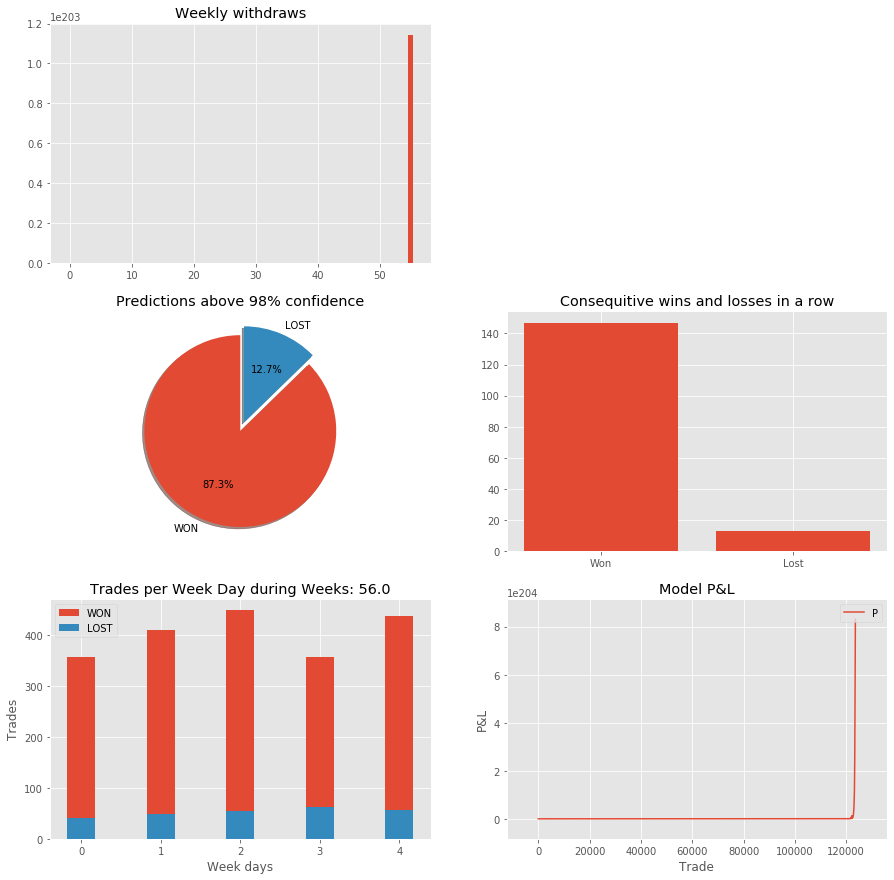

In [83]:
plt.style.use('ggplot')
f = plt.figure(figsize=(15,15))


ax1 = f.add_subplot(321)
ax1.set_title('Weekly withdraws')
ax1.bar(np.arange(len(weekly_withdraws)),weekly_withdraws)


ax3 = f.add_subplot(323)
labels = 'WON', 'LOST'
sizes = [won_trades, lost_trades]
explode = (0, 0.1)  
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.set_title('Predictions above 98% confidence')

ax4 = f.add_subplot(324)
ax4.set_title('Consequitive wins and losses in a row')
x = ['Won','Lost']
ax4.bar(x, [max_won,max_lost])
ax4.set_xticks(x, ('Won','Lost'))

ax5 = f.add_subplot(325)
TradesWonWeekDay = (sum(week_day_trades['Monday']), sum(week_day_trades['Tuesday']),sum(week_day_trades['Wendsday']), sum(week_day_trades['Monday']), sum(week_day_trades['Friday']))
TradesLostWeekDay = (week_day_trades['Monday'][1], week_day_trades['Tuesday'][1], week_day_trades['Wendsday'][1], week_day_trades['Thursday'][1], week_day_trades['Friday'][1])
p1 = plt.bar(np.arange(5) , TradesWonWeekDay, 0.35 )
p2 = plt.bar(np.arange(5), TradesLostWeekDay, 0.35 )
ax5.set_ylabel('Trades')
ax5.set_title('Trades per Week Day during Weeks: ' + str(traded_weeks))
ax5.set_xticks(np.arange(5), ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
ax5.set_xlabel('Week days')
ax5.legend((p1[0], p2[0]), ('WON', 'LOST'))

ax6 = f.add_subplot(326)
ax6.margins(0.1) 
ax6.plot(profit_loss)
ax6.set_title('Model P&L')
ax6.set_ylabel('P&L')
ax6.set_xlabel('Trade')
ax6.legend('Profit', loc='upper right')

plt.show()



## Part 7. - Make live prediction using Aplhafx API

#### data downloaded from AlphaVantage free API
API KEY: ZFO5PFRVOX72B03T

### Download live data in csv format

In [ ]:

current_dataset = pd.read_csv('https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=1min&apikey=ZFO5PFRVOX72B03T&datatype=csv')

### Get prediction time

In [ ]:
prediction_time = current_dataset.values[0:1,0:1][0][0]

### Modified funtcion for live feature engineering

In [ ]:
def FeatureEnginering_AplhaVantage(MyRawData, Quite=True):
    #calculate time series
    #MyRawData['WeekDay'] = ((pd.to_datetime(MyRawData['Gmt time'], format='%d.%m.%Y %H:%M:%S.000', utc=True)).dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['timestamp'] = pd.to_datetime(MyRawData['timestamp'], format='%Y-%m-%d %H:%M:%S', utc=True)
    #MyRawData['timestamp2'] = MyRawData['timestamp2'].dt.date
    #MyRawData['timestamp2'] = pd.to_datetime(MyRawData['timestamp2'])
    MyRawData['WeekDay'] = (MyRawData['timestamp'].dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['Hour'] = (MyRawData['timestamp'].dt.hour.astype(dtype=np.int64)/23)
    MyRawData['Minute'] = (MyRawData['timestamp'].dt.minute.astype(dtype=np.int64)/59)
    if Quite == False: print('Step 1: Time conversion to Weekday, Hour, Minute')
    
    #calculate candle size parameters in pips
    MyRawData['BodyPips'] = abs((MyRawData['open']-MyRawData['close']) * 10000)
    MyRawData['WickUpPips'] = (abs(MyRawData['open']-MyRawData['high']) * 10000)
    MyRawData['WickDownPips'] = (abs(MyRawData['close']-MyRawData['low']) * 10000)
    #calculate candle type
    MyRawData['type'] = 0
    MyRawData.loc[MyRawData['close'] > MyRawData['open'] , 'type'] = 1
    if Quite == False: print('Step 2: Calculation Body,Wicks sizes and type of candle')
    
    MyRawData['EmaSlow'], MyRawData['EmaFast'], MyRawData['MACD'] = moving_average_convergence(MyRawData['close'].values, nslow=26, nfast=12)                   
    if Quite == False: print('Step 3: Calculate MACD')
    MyRawData['Ema9'] = moving_average(MyRawData['MACD'].values, 9, type='exponential')
    if Quite == False: print('Step 4: Calculate EMA 9')
    MyRawData['RSI'] = relative_strength(MyRawData['close'].values) 
    if Quite == False: print('Step 5: Calculate RSI')

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    MyRawData=MyRawData[::-1]
    MyRawData['Rolling Mean'] = MyRawData['close'].rolling(window=21).mean()
    MyRawData['Bollinger High'] = MyRawData['close'].rolling(window=21).mean() + (MyRawData['close'].rolling(window=21).std() * 2)
    MyRawData['Bollinger Low'] = MyRawData['close'].rolling(window=21).mean() - (MyRawData['close'].rolling(window=21).std() * 2)
    MyRawData=MyRawData[::-1]
    if Quite == False: print('Step 6: Calculate Bolinger Bands')
    
    #add 10 more history candle sticks
    for CandleCount in range(10):
        ActualCandleCount = CandleCount + 1
        MyRawData['BodyPips' + '_' + str(ActualCandleCount)] = MyRawData['BodyPips'].shift(-ActualCandleCount)
        MyRawData['WickUpPips' + '_' + str(ActualCandleCount)] = MyRawData['WickUpPips'].shift(-ActualCandleCount)
        MyRawData['WickDownPips' + '_' + str(ActualCandleCount)] = MyRawData['WickDownPips'].shift(-ActualCandleCount)
        MyRawData['WeekDay' + '_' + str(ActualCandleCount)] = MyRawData['WeekDay'].shift(-ActualCandleCount)
        MyRawData['Hour' + '_' + str(ActualCandleCount)] = MyRawData['Hour'].shift(-ActualCandleCount)
        MyRawData['Minute' + '_' + str(ActualCandleCount)] = MyRawData['Minute'].shift(-ActualCandleCount)
        MyRawData['type' + '_' + str(ActualCandleCount)] = MyRawData['type'].shift(-ActualCandleCount)
        MyRawData['EmaSlow' + '_' + str(ActualCandleCount)] = MyRawData['EmaSlow'].shift(-ActualCandleCount)
        MyRawData['EmaFast' + '_' + str(ActualCandleCount)] = MyRawData['EmaFast'].shift(-ActualCandleCount)
        MyRawData['MACD' + '_' + str(ActualCandleCount)] = MyRawData['MACD'].shift(-ActualCandleCount)
        MyRawData['Ema9' + '_' + str(ActualCandleCount)] = MyRawData['Ema9'].shift(-ActualCandleCount)
        MyRawData['RSI' + '_' + str(ActualCandleCount)] = MyRawData['RSI'].shift(-ActualCandleCount)
        MyRawData['Rolling Mean' + '_' + str(ActualCandleCount)] = MyRawData['Rolling Mean'].shift(-ActualCandleCount)
        MyRawData['Bollinger High' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger High'].shift(-ActualCandleCount)
        MyRawData['Bollinger Low' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger Low'].shift(-ActualCandleCount)
        if Quite == False: print('Step 7: Generating candle backwards [Candle: ' + str(ActualCandleCount) +']')


    #del MyRawData['timestamp2']
    del MyRawData['timestamp']
    del MyRawData['open']
    del MyRawData['high']
    del MyRawData['low']
    del MyRawData['close']
    if Quite == False: print('Step 9: Deleting waste columns')

    return MyRawData



### Live feature engineering

In [ ]:

current_dataset=FeatureEnginering_AplhaVantage(current_dataset)


### Show live data

In [ ]:
#current_dataset

### Get the first row to make prediction

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
current_dataset = min_max_scaler.fit_transform(current_dataset)
current_predict = current_dataset[:1]

### Make the live prediction

In [ ]:
prediction_live = model.predict(current_predict)

In [ ]:
if np.argmax(prediction_live[0]) == 0: Type='RED'
if np.argmax(prediction_live[0]) == 0: Type='GREEN'
if prediction_live[0][0] > 0.99 or prediction_live[0][0] < 0.01:
    if  Type=='RED': Action='PUT'
    if  Type=='GREEN': Action='CALL'
else:
    Action='Wait'
print('Prediction time: ' + str(prediction_time) + ', Next candle will be: ' + Type + ' for ' + str(round(prediction_live[0][0],5)) + '%' + ' --> Action: ' + Action)

In [ ]:
print('Prediction time: 2019-06-24 11:38:00 Next candle will be: GREEN for 0.89005% Action: Wait')

# Total time required to run this notebook:

In [ ]:
Notebook_timer.kill()

# Reccurent predictions function:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def Reccurent_predict():
    current_dataset = pd.read_csv('https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=1min&apikey=ZFO5PFRVOX72B03T&datatype=csv')
    prediction_time = current_dataset.values[0:1,0:1][0][0]
    current_dataset=FeatureEnginering_AplhaVantage(current_dataset, True)
    min_max_scaler = preprocessing.MinMaxScaler()
    current_dataset = min_max_scaler.fit_transform(current_dataset)
    current_predict = current_dataset[:1]
    prediction_live = model.predict(current_predict)
    if np.argmax(prediction_live[0]) == 0: Type='RED'
    if np.argmax(prediction_live[0]) == 0: Type='GREEN'
    if prediction_live[0][0] > 0.99:
        if  Type=='RED': Action='PUT'
        if  Type=='GREEN': Action='CALL'
    if prediction_live[0][0] < 0.01:
        if  Type=='RED': Action='CALL'
        if  Type=='GREEN': Action='PUT'
    else:
        Action='Wait'
    print('Prediction time: ' + str(prediction_time) + ', Next candle will be: ' + Type + ' for ' + str(round(prediction_live[0][0],5)) + '%' + ' --> Action: ' + Action)


In [ ]:
Reccurent_predict()

In [ ]:
import time
starttime=time.time()
while True:
    Reccurent_predict()
    time.sleep(60.0 - ((time.time() - starttime) % 60.0))